# __Ocean regimes indicator__: Model development notebook

Create a Gaussian Mixtures Model trained with a dataset of time series

***
ds : initial dataset (lat, lon, week)

X : staked dataset (sampling, week, week_reduced)

ds_labels: unstacked final dataset (lat, lon, week)
***

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from sklearn import mixture

import Plotter_OR
from Plotter_OR import Plotter_OR 

from BIC_calculation_OR import *

from io_OR import *

import subprocess

import joblib

from preprocessing import *

## Model parameters
***

.....

In [2]:
# number of classes
K=7

## Load training dataset
***

__Choose training dataset__

One year of Ocean Color data in the Mediterranean Sea:  OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082 product

..........

In [ ]:
CMEMS_user = '########'
CMEMS_password = '#######'

..............

In [3]:
# geographical extent
geo_extent = [-5, 42, 30, 46] # [min lon, max lon, min lat, max lat]
# time extent
time_extent = ["2019-01-01", "2019-12-31"] # ["min date", "max date"]
# variable to be predict
var_name = 'CHL' # name in dataset
# file name
file_name = 'oceancolour_glo_chl_l4_rep_observations_009_082_2019.nc'

__Load training dataset__

.......

In [ ]:
bashCommand = 'python -m motuclient -u ' + CMEMS_user + ' -p ' + CMEMS_password + ' -m "http://my.cmems-du.eu/motu-web/Motu" \
-s OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082-TDS -d dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep \
-x ' + str(geo_extent[0]) + ' -X ' + str(geo_extent[1]) + ' -y ' + str(geo_extent[2]) + ' -Y ' + str(geo_extent[3]) + \
' -t "' + time_extent[0] + '" -T "' + time_extent[1] + '" -z 0.0 -Z 2500.0 \
-v ' + var_name + ' -o datasets -f ' + file_name
print(bashCommand)
sp = subprocess.call(bashCommand, shell=True)

In [ ]:
#if I don't want to downloas dataset
#file_path = 'datasets/dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep_1611225376956.nc' #in datarmor
#file_path = 'datasets/dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep_1610026811620.nc'

Open dataset

........

In [4]:
file_path = 'datasets/' + file_name
ds = xr.open_dataset(file_path)

ds['time'] = ds.indexes['time'].to_datetimeindex()
ds.time.attrs['axis'] = 'T'

#print(ds)
ds

<xarray.Dataset>
Dimensions:  (lat: 385, lon: 1128, time: 365)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
  * lat      (lat) float32 46.020832 45.979164 45.9375 ... 30.062498 30.020832
  * lon      (lon) float32 -4.9791613 -4.9374948 ... 41.937508 41.97917
Data variables:
    CHL      (time, lat, lon) float32 ...
Attributes:
    comment:                      average
    distribution_statement:       See CMEMS Data License
    site_name:                    GLO
    parameter_code:               CHL
    creation_time:                16:39:54 UTC
    creation_date:                2020-11-05 UTC
    nb_grid_bins:                 37324800
    easternmost_longitude:        180.0
    references:                   http://www.globcolour.info GlobColour has b...
    registration:                 5
    stop_date:                    2020-07-01 UTC
    lon_step:                     0.041666668
    cmems_product_id:             OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009...
    naming_authority:             CMEMS
    northernmost_valid_latitude:  86.666664
    grid_mapping:                 Equirectangular
    title:                        dataset-oc-glo-bio-multi-l4-chl_interpolate...
    period_end_day:               20200630
    duration_time:                PT151043S
    DPM_reference:                GC-UD-ACRI-PUG
    product_name:                 20200630_d-ACRI-L4-CHL-MULTI_4KM-GLO-REP
    netcdf_version_id:            4.3.3.1 of Jul  8 2016 18:15:50 $
    platform:                     Aqua,Suomi-NPP,Sentinel-3a,JPSS-1 (NOAA-20)...
    northernmost_latitude:        90.0
    IODD_reference:               GC-UD-ACRI-PUG
    stop_time:                    08:47:59 UTC
    file_quality_index:           0
    start_date:                   2020-06-29 UTC
    product_level:                4
    period_start_day:             20200630
    software_name:                globcolour_l3_reproject
    citation:                     The Licensees will ensure that original CME...
    software_version:             2020.0
    start_time:                   14:50:37 UTC
    easternmost_valid_longitude:  180.00002
    nb_bins:                      37324800
    southernmost_valid_latitude:  -54.458336
    nb_equ_bins:                  8640
    lat_step:                     0.041666668
    sensor_name_list:             MOD,VIR,OLA,VJ1,OLB
    institution:                  ACRI
    publication:                  Gohin, F., Druon, J. N., Lampert, L. (2002)...
    grid_resolution:              4.6383123
    sensor_name:                  MODISA,VIIRSN,OLCIa,VIIRSJ1,OLCIb
    product_type:                 day
    sensor:                       Moderate Resolution Imaging Spectroradiomet...
    Conventions:                  CF-1.4
    westernmost_valid_longitude:  -180.0
    contact:                      servicedesk.cmems@acri-st.fr
    westernmost_longitude:        -180.0
    source:                       surface observation
    earth_radius:                 6378.137
    southernmost_latitude:        -90.0
    pct_bins:                     100.0
    cmems_production_unit:        OC-ACRI-NICE-FR
    period_duration_day:          P1D
    history:                      
    nb_valid_bins:                18893040
    pct_valid_bins:               50.61792695473251
    parameter:                    Chlorophyll-a concentration
    History:                      Translated to CF-1.0 Conventions by Netcdf-...
    geospatial_lat_min:           30.020832061767578
    geospatial_lat_max:           46.02083206176758
    geospatial_lon_min:           -4.979161262512207
    geospatial_lon_max:           41.97917175292969

__Quick plot__

...........

In [ ]:
ds[var_name].isel(time=11).plot();

.................

In [ ]:
bins = np.arange(int(ds[var_name].min().values), int(ds[var_name].max().values))
ds[var_name].plot.hist(bins=bins);

## Preprocessing
***

...............

__1. Weekly mean for each pixel__

............

In [5]:
X = weekly_mean(ds, var_name=var_name)

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/accessor_dt.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  field_values = getattr(values_as_series.dt, name).values
/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


__2) Reduce lat lon dimensions to sampling dimension__

......................

In [6]:
X = reduce_dims(X)

__3. Delate all NaN time series using mask__

.................

In [7]:
X, mask = delate_NaNs(X, var_name =var_name, mask_path='datasets/Mediterranean_mask.nc')

Interpolation is applied


.............

In [ ]:
mask['mask'].plot()
# if create mask is a 3d mask
#mask['mask'].isel(feature=0).plot();

__4. Scaler__

choose the best scaler: https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer

Apply sklearn __StandardScaler__: 
Standardize features by removing the mean and scaling to unit variance
The standard score of a sample x is calculated as:

    z = (x - u) / s
    
where u is the mean of the training samples or zero if `with_mean=False`, and s is the standard deviation of the training samples or one if `with_std=False`.
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. 

shape (n_samples, n_features), calculate mean for each feature

In [8]:
X = scaler(X, var_name=var_name)

__5. PCA__

Apply __Principal component analysis__ (PCA):
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
If `0 < n_components < 1` and `svd_solver == 'full'`, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

<xarray.Dataset>
Dimensions:      (feature: 52, feature_reduced: 39, sampling: 140700)
Coordinates:
  * feature      (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * sampling     (sampling) MultiIndex
  - lon          (sampling) float64 -4.979 -4.979 -4.979 ... 36.15 36.15 36.15
  - lat          (sampling) float64 36.44 36.4 36.35 36.31 ... 36.73 36.69 36.65
Dimensions without coordinates: feature_reduced
Data variables:
    CHL          (sampling, feature) float32 0.7913663 1.2838366 ... 0.37713894
    CHL_scaled   (sampling, feature) float32 2.4403603 4.81741 ... 0.1729808
    CHL_reduced  (sampling, feature_reduced) float32 34.07583 ... -0.48350847

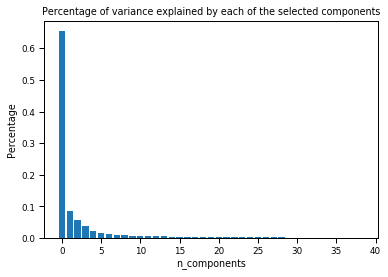

In [9]:
X = apply_PCA(X, var_name=var_name, plot_var=True)
X

Plot histogram in time

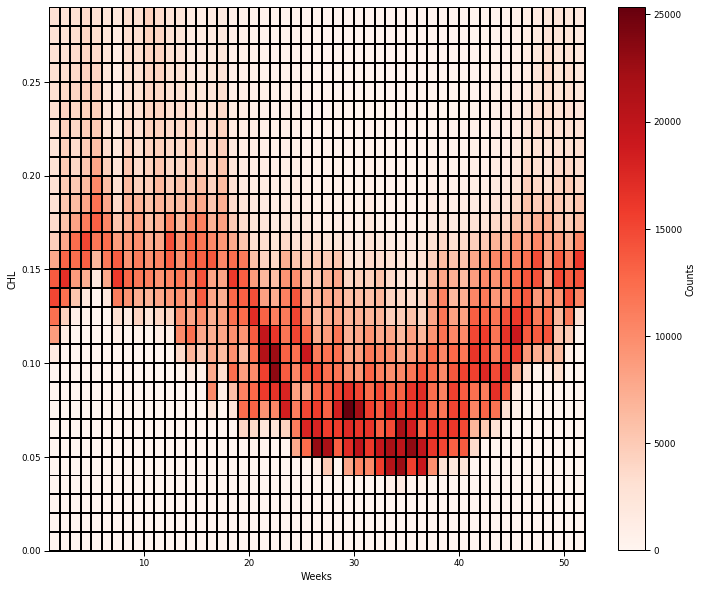

In [10]:
hist_2D(X, var_name=var_name, bins=np.arange(0,0.3,0.01), xlabel='Weeks')

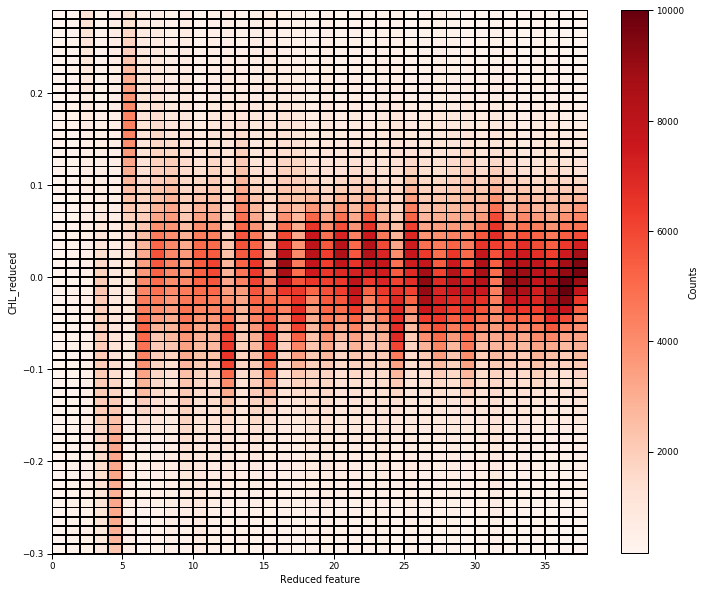

In [13]:
hist_2D(X, var_name='CHL_reduced', bins=np.arange(-0.3,0.3,0.01), xlabel='Reduced feature')

## Create and train model
***

.............

### Create model

In [ ]:
model = mixture.GaussianMixture(n_components=K, covariance_type='full')
model

In [ ]:
# option kmeans? 
#from sklearn.cluster import KMeans
#k=7
#model = KMeans(n_clusters=7)
#model

### Fit model

In [ ]:
X_labels = model.fit_predict(X[var_name + "_reduced"])
X = X.assign(variables={"GMM_labels":(('sampling'),X_labels)})

Calculate __robustness__ for development plots

- Predict posterior probability of each component given the data

In [ ]:
X_proba = model.predict_proba(X[var_name + "_reduced"])
X = X.assign(variables={"GMM_post":(('sampling','k'),X_proba)})
print(X)
#X

- Calculate robustness

In [ ]:
maxpost = X["GMM_post"].max(dim="k")
K = len(X["GMM_labels"])
robust = (maxpost - 1. / K) * K / (K - 1.)

Plist = [0, 0.33, 0.66, 0.9, .99, 1]
rowl0 = ('Unlikely', 'As likely as not', 'Likely', 'Very Likely', 'Virtually certain')
robust_id = np.digitize(robust, Plist) - 1

In [ ]:
X = X.assign(variables={"GMM_robustness":(('sampling'), robust), "GMM_robustness_cat":(('sampling'), robust_id)})
X["GMM_robustness_cat"].attrs['legend'] = rowl0
print(X)
#X

__Unstack dataset__

In [ ]:
ds_labels = unstack_dataset(ds, X, mask, var_name=var_name)
ds_labels

## Development plots
***

............

In [ ]:
P = Plotter_OR(ds_labels, model, coords_dict={'latitude':'lat', 'longitude':'lon', 'feature': 'feature'})

#### __1. Scatter plot__

............

In [ ]:
P.scatter_PDF(var_name = var_name + '_reduced')
P.save_BlueCloud('figures/scatter_PDF_EX_chl.png')

#### __2. BIC__

...........

__User input__

In [ ]:
corr_dist = 50 # correlation distance in km
Nrun = 10 # number of runs for each k
NK = 20 # max number of classes to explore

__BIC calculation__

.................

In [ ]:
BIC, BIC_min = BIC_calculation(X=X, coords_dict={'latitude':'lat', 'longitude':'lon'}, 
                               corr_dist=corr_dist,
                               feature_name='feature_reduced', var_name= 'CHL_reduced',
                               Nrun=Nrun, NK=NK)

__BIC plot__

In [ ]:
plot_BIC(BIC, NK=NK)
P.save_BlueCloud('figures/BIC_EX_chl.png', bic_fig='yes')

__Optimized number of classes__

In [ ]:
BIC_min

.............

#### __3. Robustness__

....................

In [ ]:
P.plot_robustness()
P.save_BlueCloud('figures/robustness_EX_chl.png')

## Refit and save model
***

........

In [ ]:
# appropriate number of classes
K = BIC_min
K = 7

model = mixture.GaussianMixture(n_components=K, covariance_type='full')
model.fit_predict(X[var_name + "_reduced"])

..........

In [ ]:
joblib.dump(model, 'models/test_modelOR_mediterranean_chl_2019_k7.sav')
#model.to_netcdf('models/test_modelOR_mediterranean_chl_2019_k7.nc')

In [ ]:
to_netcdf(model, ncfile='models/test_modelOR_mediterranean_chl_2019_k7.nc')